In [1]:
# importazione librerie utili
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import normalize
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from boruta import BorutaPy 
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, precision_score, matthews_corrcoef, cohen_kappa_score


In [2]:
#Funzione per calcolare la specificità TrueNeg/TotSani

def specificity_score(ypred,y):
     tn, fp, fn, tp = confusion_matrix(ypred, y).ravel()
    
     return (tn/(tn+fp))

In [3]:
#Funzione per calcolare la media
def media (array, int):
    c=0
    for i in array:
        c=c+i
    return (c/int)

In [4]:
def apply_boruta(X_train,y_train, X_test,colname, rf):
    boruta_feature_selector = BorutaPy(rf, n_estimators='auto', verbose=0, max_iter = 50, perc = 40)

    boruta_feature_selector.fit(X_train, y_train)
    indexes = np.where(boruta_feature_selector.support_ == True)
    #print(colname[indexes])
            
    X_train_selected=boruta_feature_selector.transform(X_train)
    X_test_selected=boruta_feature_selector.transform(X_test)
    return indexes,X_train_selected,X_test_selected 

In [5]:
def apply_rfe(X_train,y_train, X_test,colname, rf):
    selector = RFE(rf, n_features_to_select=20, step=3)
    selector = selector.fit(X_train, y_train)
              
    X_train_selected=selector.transform(X_train)
    X_test_selected=selector.transform(X_test)
    indexes = np.where(selector.support_ == True) 
    #print(colname[indexes])
    
    return indexes,X_train_selected,X_test_selected 

In [6]:
#TUTTE LE VARIABILI
#carico il dataset
data = pd.read_csv(r'C:\Users\Utente\anaconda3\Lib\site-packages\pandas\io\data_covnet_score-imputed_missRF_increasing_1.txt')
print(data.shape)

# fisso il numero di iterazioni di cross-validation
nit=15

# fisso il numero di fold della cross vvalidation
n_fold=10

#creo un array di sole features
features = [f for f in data.columns if f not in ['LABEL']]
#creo un array con solo i valori delle features.
X = data[features].values

#ravel() mi fa diventare l'array monodimensionale.
Y = data['LABEL'].values.ravel()

#definisco una random forest
rf = RandomForestClassifier(n_estimators = 101, max_depth=11, max_features=None, max_samples=0.75,class_weight="balanced")


#creo un array monodimensionale lungo quanto "altri" ma solo di 0. 
y_pred=np.zeros(Y.shape[0])
ytrue = np.zeros(Y.shape[0])
conta =np.zeros(Y.shape[0])

#creo degli array che mi servono per creare i grafici, dove andrò a salvare le features che sono selezionate
parzial_featuresboruta = list()
final_featuresboruta = list()
parzial_featuresrfe = list()
final_featuresrfe = list()
    
#creo degli array dove salvo di volta in volta il valore degli indici statistici
spec=np.zeros(nit)
sens = np.zeros(nit)
f1=np.zeros(nit)
acc=np.zeros(nit)
prec=np.zeros(nit)
matt =np.zeros(nit)
choen=np.zeros(nit)    


(301, 42)


In [7]:
def boruta():
    
    for niter in range(nit):
        skf = StratifiedKFold(n_splits=n_fold)

        for train_index, test_index in skf.split(X, Y):
               
                # mi creo i punti di train e di test
                X_train, X_test = X[train_index,:], X[test_index,:]
                #creo le label del train e quelle del test
                y_train, y_test = Y[train_index], Y[test_index]

                #BORUTA
               
                indexes, X_train_selected, X_test_selected = apply_boruta(X_train,y_train, X_test,data.columns, rf)
           
                for x in np.nditer(indexes):
                    parzial_featuresboruta.append(features[x])
                
                clf = rf.fit(X_train_selected, y_train)

                y_pred[test_index] =clf.predict(X_test_selected)
               




        #fine ciclo for train_index, test_index in skf.split(X, Y):

        # QUI ho le predizioni ottenute con questpo split del dataset
        #mi salvo il valore di ogni indice statistico, nell'array. Dovrò farne la media.
        tp, tn, fp, fn = confusion_matrix(y_pred, Y).ravel()
        f1[niter]=f1_score(y_pred,Y)
        sens[niter] = recall_score(y_pred,Y)
        acc[niter]=accuracy_score(y_pred,Y)
        prec[niter]=precision_score(y_pred,Y)
        matt[niter]=matthews_corrcoef(y_pred,Y)
        choen[niter]=cohen_kappa_score(y_pred,Y)
        spec[niter]=specificity_score(y_pred,Y)

        #fine for niter in range(nit) -> 

   # X_filtered = boruta_feature_selector.transform(X)
    #indexes = np.where(boruta_feature_selector.support_ == True)
  

    #stampo la media di tutti gli indici statistici per Boruta.
    print("Specificità: ",media(spec,nit),"F_score: ",media(f1,nit), " Sens: ",media(sens,nit)," Accuratezza: ", media(acc,nit), " Precision: ",media(prec,nit), " Matthews: ",media(matt,nit), " Choen Kappa: ", media(choen, nit))




In [8]:
def rfe():

    for niter in range(nit):
        skf = StratifiedKFold(n_splits=n_fold)

        for train_index, test_index in skf.split(X, Y):
            
                # mi creo i punti di train e di test
                X_train, X_test = X[train_index,:], X[test_index,:]
                #creo le label del train e quelle del test
                y_train, y_test = Y[train_index], Y[test_index]

                
                #RFE
                
                indexes, X_train_selected, X_test_selected=apply_rfe(X_train,y_train, X_test,data.columns, rf)


                for x in np.nditer(indexes):
                    parzial_featuresrfe.append(features[x])

                clf = rf.fit(X_train_selected, y_train)

                y_pred[test_index] =clf.predict(X_test_selected)
             
        #fine ciclo for train_index, test_index in skf.split(X, Y):

        # QUI ho le predizioni ottenute con questo split del dataset
        #mi salvo il valore di ogni indice statistico, nell'array. Dovrò farne la media.
        tp, tn, fp, fn = confusion_matrix(y_pred, Y).ravel()
        f1[niter]=f1_score(y_pred,Y)
        sens[niter] = recall_score(y_pred,Y)
        acc[niter]=accuracy_score(y_pred,Y)
        prec[niter]=precision_score(y_pred,Y)
        matt[niter]=matthews_corrcoef(y_pred,Y)
        choen[niter]=cohen_kappa_score(y_pred,Y)
        spec[niter]=specificity_score(y_pred,Y)

    #fine for niter in range(nit) -> 

    #X_filtered = selector.transform(X)
    #indexes = np.where(selector.support_ == True)
    #stampo la media di tutti gli indici statistici per RFE.
    print("Specificità: ",media(spec,nit),"F_score: ",media(f1,nit), " Sens: ",media(sens,nit)," Accuratezza: ", media(acc,nit), " Precision: ",media(prec,nit), " Matthews: ",media(matt,nit), " Choen Kappa: ", media(choen, nit))




In [9]:
boruta()
print()

#creo un array lungo qunto le features in cui andrò a salvare il numero di volte in cui una features è stata selezionata
contaboruta=[0]*41


#creo degli array per salvarmi quante volte una features è stata selezionata, in base a una divisione del dataset,
#così riuscirò a ottenere dei grafici ridotti e sensati
primadivisioneboruta=[0]*14 #da CAT.Fever a INT.No.Symptoms + INT.Symptoms.No.days--> 26esimaposizione (quindi25)0-12+25
secondadivisioneboruta=[0]*10 #da CAT.Pneumo.asthma a INT.No.Comorbidities 13-22
terzadivisioneboruta=[0]*8 #23-24-26-31 no 25 CAT.Sex,INT.Age
quartadivisioneboruta=[0]*9  #INT.ALT-NUM.Haematocrit 32-40

#Le variabili sotto mi servono per tener conto fin dove sono arrivato a riempire i vari array.
a=0
primo=0
secondo=0
terzo=0
quarto=0

for i in features:
  c=parzial_featuresboruta.count(i)
  contaboruta[a]=c  
#in base alle divisioni del dataset fatte sopra riempio gli array, a seconda del valore di a.
  if (a<=12 or a==25):
    primadivisioneboruta[primo]=c
    primo=primo+1
  if(a>=13 and a<=22):
    secondadivisioneboruta[secondo]=c
    secondo=secondo+1
  if(a>=23 and a<=31 and a!=25):
    terzadivisioneboruta[terzo]=c
    terzo=terzo+1
  if (a>=32 and a<=40):
    quartadivisioneboruta[quarto]=c
    quarto=quarto+1
  print(i,'        ', c, c/(nit*n_fold))
  a=a+1  
  if (c>90):
    final_featuresboruta.append(i)
print(final_featuresboruta)
print(contaboruta)

Specificità:  0.7995760310898913 F_score:  0.5231949931563332  Sens:  0.6221580560766725  Accuratezza:  0.7621262458471759  Precision:  0.4521072796934866  Matthews:  0.37872296516791953  Choen Kappa:  0.3701071787268123

CAT.Fever          3 0.02
CAT.Cough          0 0.0
CAT.Dyspnea          6 0.04
CAT.IR          0 0.0
CAT.Myalgias          0 0.0
CAT.Other          0 0.0
CAT.Syncope          0 0.0
CAT.Asthenia          0 0.0
CAT.Vomiting.Nausea          96 0.64
CAT.Diarrhea          14 0.09333333333333334
CAT.Headache          0 0.0
CAT.Pharingeal.pain          0 0.0
INT.No.Symptoms          143 0.9533333333333334
CAT.Pneumo.asthma          0 0.0
CAT.Pneumo.BPCO          0 0.0
CAT.Neoplasia.last.5.years          63 0.42
CAT.Smoke          0 0.0
CAT.Arterial.hypertension          0 0.0
CAT.Cardiovascular.pathologies          12 0.08
CAT.Diabetes          72 0.48
CAT.Obesity          0 0.0
CAT.Celebral.stroke          0 0.0
INT.No.Comorbidities          141 0.94
CAT.Sex          0 0.0


In [10]:
rfe()
print()
#creo un array lungo qunto le features in cui andrò a salvare il numero di volte in cui una features è stata selezionata
contarfe=[0]*41

#creo degli array per salvarmi quante volte una features è stata selezionata, in base a una divisione del dataset,
#così riuscirò a ottenere dei grafici ridotti e sensati

primadivisionerfe=[0]*14 #da CAT.Fever a INT.No.Symptoms + INT.Symptoms.No.days--> 26esimaposizione (quindi25)0-12+25
secondadivisionerfe=[0]*10 #da CAT.Pneumo.asthma a INT.No.Comorbidities 13-22
terzadivisionerfe=[0]*8 #23-24-26-31 no 25 CAT.Sex,INT.Age
quartadivisionerfe=[0]*9  #INT.ALT-NUM.Haematocrit 32-40

#creo degli array per salvarmi il nome delle features, secondo la divisione del dataset che voglio rappresentare graficamente
feat1=[0]*14
feat2=[0]*10
feat3=[0]*8
feat4=[0]*9

#Le variabili sotto mi servono per tener conto fin dove sono arrivato a riempire i vari array.
a=0
primo=0
secondo=0
terzo=0
quarto=0

for i in features:
  c=parzial_featuresrfe.count(i)
  contarfe[a]=c  
    #in base alle divisioni del dataset fatte sopra riempio gli array, a seconda del valore di a.
  if (a<=12 or a==25):
    primadivisionerfe[primo]=c
    feat1[primo]=i
    primo=primo+1
    
  if(a>=13 and a<=22):
    secondadivisionerfe[secondo]=c
    feat2[secondo]=i
    secondo=secondo+1
    
  if(a>=23 and a<=31 and a!=25):
    terzadivisionerfe[terzo]=c
    feat3[terzo]=i
    terzo=terzo+1
    
  if (a>=32 and a<=40):
    quartadivisionerfe[quarto]=c
    feat4[quarto]=i
    quarto=quarto+1
    
  print(i,'        ', c, c/(nit*n_fold))
  a=a+1  
  if (c>90):
    #ottengo le features finali scelte da RFE
    final_featuresrfe.append(i)
print(final_featuresrfe)
print(contarfe)

Specificità:  0.8027123822359999 F_score:  0.5317972080682569  Sens:  0.6226124075925088  Accuratezza:  0.7638981173864895  Precision:  0.464367816091954  Matthews:  0.3858158242224361  Choen Kappa:  0.3784724030045324

CAT.Fever          2 0.013333333333333334
CAT.Cough          5 0.03333333333333333
CAT.Dyspnea          15 0.1
CAT.IR          0 0.0
CAT.Myalgias          0 0.0
CAT.Other          0 0.0
CAT.Syncope          0 0.0
CAT.Asthenia          0 0.0
CAT.Vomiting.Nausea          70 0.4666666666666667
CAT.Diarrhea          8 0.05333333333333334
CAT.Headache          0 0.0
CAT.Pharingeal.pain          0 0.0
INT.No.Symptoms          144 0.96
CAT.Pneumo.asthma          0 0.0
CAT.Pneumo.BPCO          0 0.0
CAT.Neoplasia.last.5.years          39 0.26
CAT.Smoke          1 0.006666666666666667
CAT.Arterial.hypertension          0 0.0
CAT.Cardiovascular.pathologies          15 0.1
CAT.Diabetes          54 0.36
CAT.Obesity          0 0.0
CAT.Celebral.stroke          0 0.0
INT.No.Comorbidit

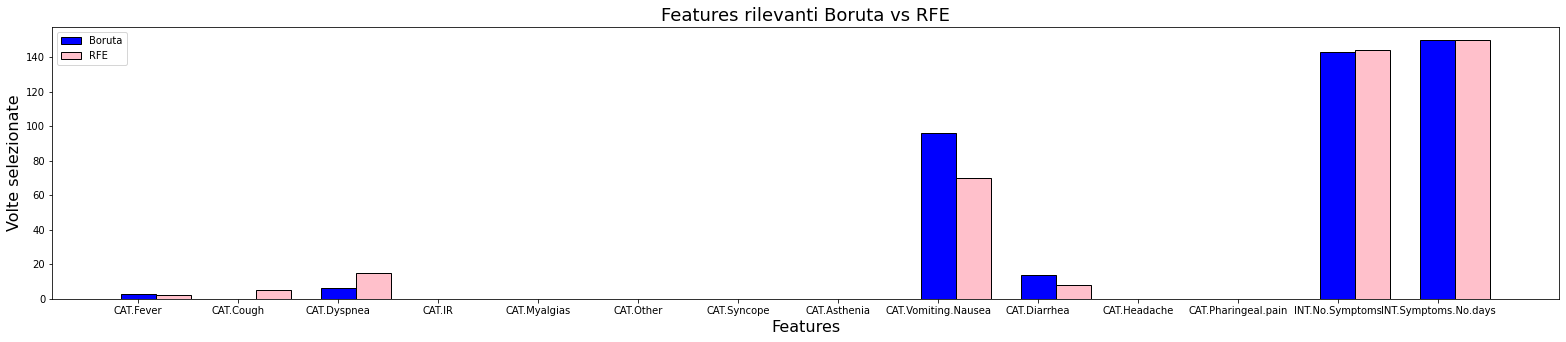

In [11]:
#definisco come variavile per l'asse x 
x=feat1
legend=['Boruta','RFE']
pos = np.arange(len(x))
#imposto lo distanza tra le colonne
bar_width = 0.35
#come y scelgo i dati inerenti a feat1
y1=primadivisioneboruta
y2=primadivisionerfe
plt.figure(figsize=(27,5))
plt.bar(pos,y1,bar_width,color='blue',edgecolor='black')
plt.bar(pos+bar_width,y2,bar_width,color='pink',edgecolor='black')
plt.xticks(pos, x)
#definisco le varie dimensioni per i caratteri delle figure
plt.xlabel('Features', fontsize=16)
plt.ylabel('Volte selezionate', fontsize=16)
plt.title('Features rilevanti Boruta vs RFE',fontsize=18)
plt.legend(legend,loc=2)
plt.show()

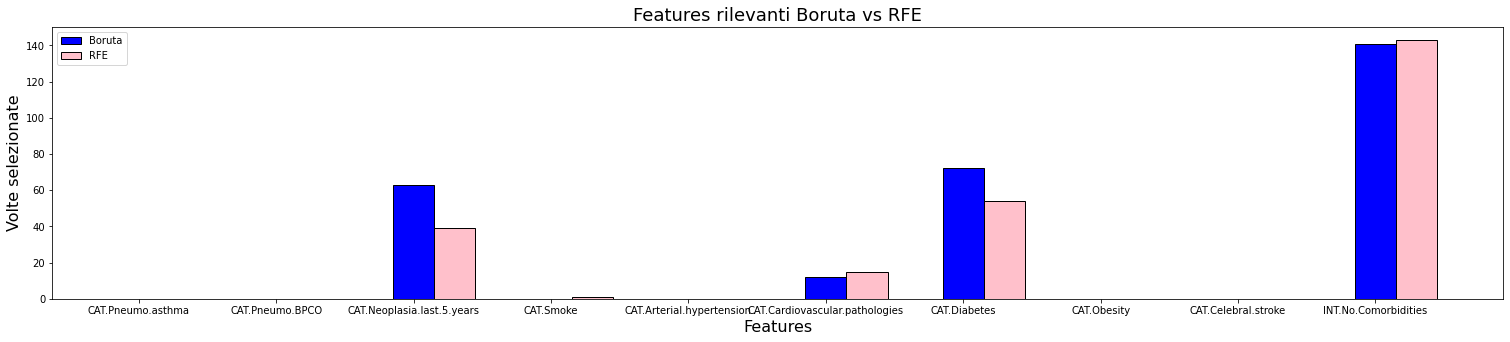

In [12]:
x=feat2
legend=['Boruta','RFE']
pos = np.arange(len(x))
bar_width = 0.3
y1=secondadivisioneboruta
y2=secondadivisionerfe
plt.figure(figsize=(26, 5))
plt.bar(pos,y1,bar_width,color='blue',edgecolor='black')
plt.bar(pos+bar_width,y2,bar_width,color='pink',edgecolor='black')
plt.xticks(pos, x)
plt.xlabel('Features', fontsize=16)
plt.ylabel('Volte selezionate', fontsize=16)
plt.title('Features rilevanti Boruta vs RFE',fontsize=18)
plt.legend(legend,loc=2)
plt.show()

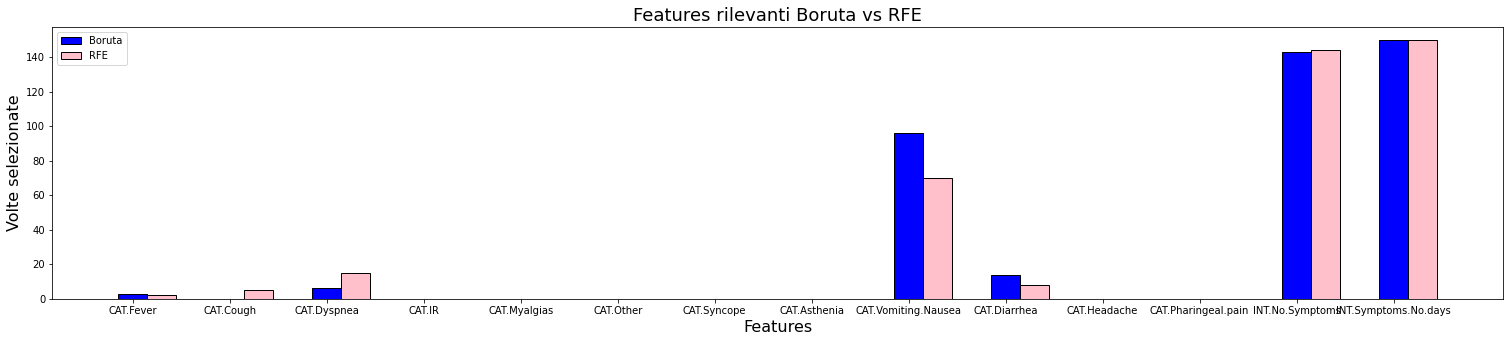

In [13]:
x=feat1
legend=['Boruta','RFE']
pos = np.arange(len(x))
bar_width = 0.3
y1=primadivisioneboruta
y2=primadivisionerfe
plt.figure(figsize=(26, 5))
plt.bar(pos,y1,bar_width,color='blue',edgecolor='black')
plt.bar(pos+bar_width,y2,bar_width,color='pink',edgecolor='black')
plt.xticks(pos, x)
plt.xlabel('Features', fontsize=16)
plt.ylabel('Volte selezionate', fontsize=16)
plt.title('Features rilevanti Boruta vs RFE',fontsize=18)
plt.legend(legend,loc=2)
plt.show()

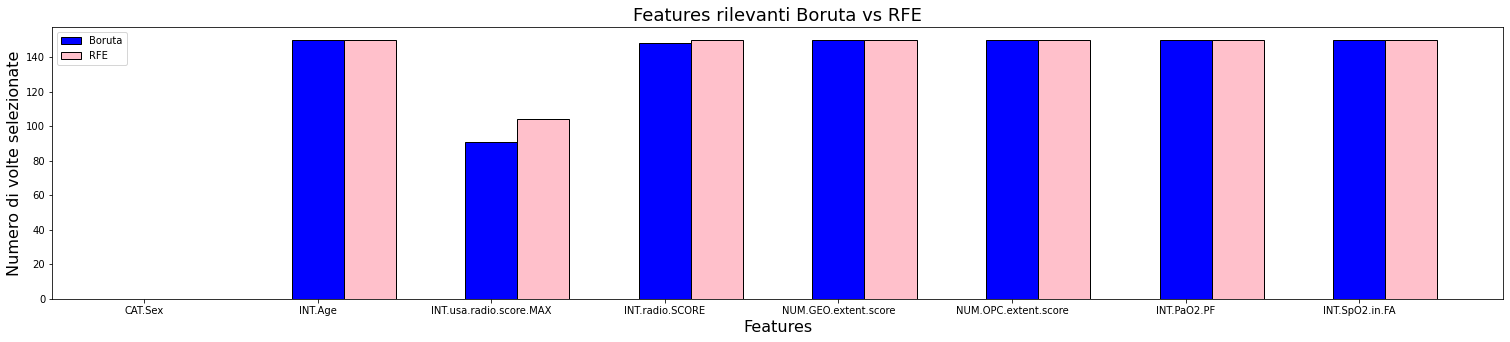

In [14]:
x=feat3
legend=['Boruta','RFE']
pos = np.arange(len(x))
bar_width = 0.3
y1=terzadivisioneboruta
y2=terzadivisionerfe
plt.figure(figsize=(26, 5))
plt.bar(pos,y1,bar_width,color='blue',edgecolor='black')
plt.bar(pos+bar_width,y2,bar_width,color='pink',edgecolor='black')
plt.xticks(pos, x)
plt.xlabel('Features', fontsize=16)
plt.ylabel('Numero di volte selezionate', fontsize=16)
plt.title('Features rilevanti Boruta vs RFE',fontsize=18)
plt.legend(legend,loc=2)
plt.show()

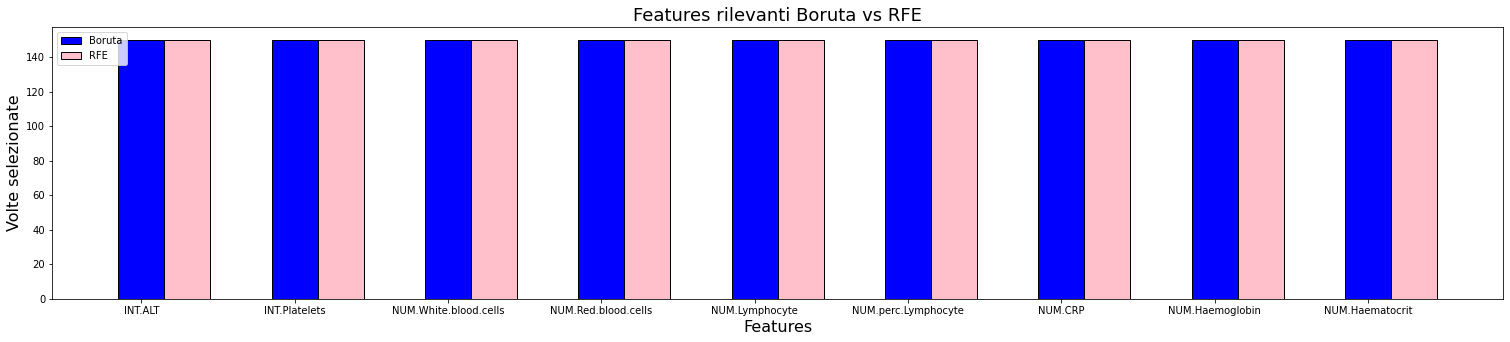

In [15]:
x=feat4
legend=['Boruta','RFE']
pos = np.arange(len(x))
bar_width = 0.3
y1=quartadivisioneboruta
y2=quartadivisionerfe
plt.figure(figsize=(26, 5))
plt.bar(pos,y1,bar_width,color='blue',edgecolor='black')
plt.bar(pos+bar_width,y2,bar_width,color='pink',edgecolor='black')
plt.xticks(pos, x)
plt.xlabel('Features', fontsize=16)
plt.ylabel('Volte selezionate', fontsize=16)
plt.title('Features rilevanti Boruta vs RFE',fontsize=18)
plt.legend(legend,loc=2)
plt.show()